# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn
from copy import copy,deepcopy

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

# Train classifier

## Definitions

In [5]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = True #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = False #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training
TRAIN = True

In [6]:
MODEL_ARC = 'ResNet50'#WideResNet ResNet101,ResNet18,ResNet34,ResNet50 CNN8
DATA = 'Cifar100'
NAME = f'{MODEL_ARC}_{DATA}_g1'

In [7]:
loss_criterion = nn.CrossEntropyLoss();SOFTMAX = False
risk_dict = None#{'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

In [8]:
params = {'train_batch_size': 128, 'validation_size': 0.1, 'test_batch_size': 100}

In [9]:
torch_data.__dict__[DATA].__init__

<function torch_data.cifar.Cifar100.__init__(self, params={'train_batch_size': 128, 'validation_size': 0.0, 'test_batch_size': 100}, download=True, data_dir='data', train=True, test=True, dataloader=True, **kwargs)>

In [55]:
data = torch_data.__dict__[DATA](data_dir = DATA_PATH,params = params,validation_as_train= True)
num_classes = data.n_classes
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

if CREATE_DIR and not os.path.isdir(weights_path):
    os.makedirs(weights_path)

Files already downloaded and verified
Files already downloaded and verified


## Upload Model

In [11]:
if not TRAIN:
    if DATA == 'ImageNet':
        pre_model = model_class(weights = weights_path.DEFAULT).to(dev)
        data.transforms_test = weights_path.DEFAULT.transforms()
        pre_model.name = NAME
        if SOFTMAX: utils.apply_softmax(pre_model)
    else:
        pre_model = model_class(num_classes = data.n_classes).to(dev)
        pre_model.load_state_dict(utils.upload_weights(weights_path))

    pre_model.eval()
    acc_model = TE.model_acc(pre_model,data.test_dataloader)
    rk_model = 1-0.01*acc_model
    print(f'Acurácia = {acc_model}')

## Train

### Baseline model

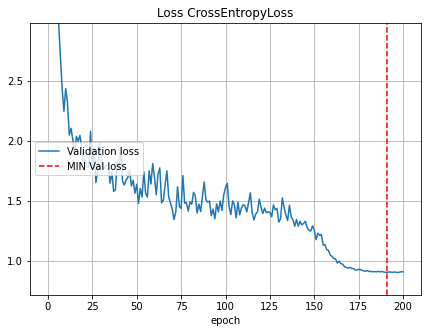

Acc_val (max): 78.15 (78.15) | Progress:: 100%|#########9| 199/200 [3:40:16<01:06, 66.08s/it]

In [12]:
N_EPOCHS_0 = 200
if TRAIN:
    loss_criterion = nn.CrossEntropyLoss()
    pre_model = model_class(num_classes = data.n_classes).to(dev)
    optimizer = torch.optim.SGD(pre_model.parameters(), lr =0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS_0)
    model_trainer = TE.Trainer(pre_model,optimizer,loss_criterion, None,data.test_dataloader,lr_scheduler = scheduler)
    model_trainer.fit(data.train_dataloader,N_EPOCHS_0, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)
    

In [13]:
pre_model.eval()
acc = TE.model_acc(pre_model,data.train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(pre_model,data.test_dataloader)
print('Conjunto de teste: acc = ', acc)
print(f'Conjunto de teste: MAX acc (argmax epoch) = {max(model_trainer.hist_val.acc_list)}({np.argmax(model_trainer.hist_val.acc_list)})')

Conjunto de treinamento: acc =  99.97555555555556
Conjunto de teste: acc =  77.92
Conjunto de teste: MAX acc (argmax epoch) = 78.15(194)


### Activation Function

In [62]:
Activation_Function = nn.Sequential(nn.Linear(data.n_classes,200),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(200,100),
                                        nn.ReLU(),
                                        nn.Linear(100,100),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(100,1), #globalpooling-max
                                        nn.Sigmoid())

class Model_Activation(nn.Module):
    def __init__(self,model,n_classes,activation) -> None:
        super().__init__()
        self.Activation_Function = activation
        self.base_model = model
        self.base_model.eval()
        utils.freeze_params(self.base_model)
    def forward(self,x):
        with torch.no_grad():
            logits = self.base_model(x)
        return self.Activation_Function(logits)
class BCELoss(nn.BCELoss):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def forward(self,y_pred,y_true):
        y_true = y_true.unsqueeze(-1).float()
        loss = super().forward(y_pred,y_true)
        return loss

In [63]:
model = Model_Activation(pre_model,data.n_classes,Activation_Function).to(dev)

loss_criterion = BCELoss()#Unc_Loss()

In [58]:
def hits_labels(data,model,transforms = None):
    from torch.utils.data import DataLoader
    with torch.no_grad():
        if transforms is not None:
            data = deepcopy(data)
            data.dataset.transform = transforms
        
        if not isinstance(data,DataLoader):
            loader = DataLoader(data,batch_size = 100,shuffle = False)
        else: loader = data
        hits = torch.tensor([],device = dev)
        for im,label in loader:
            im,label=im.to(dev),label.to(dev)
            output = model(im)
            hits = torch.cat((hits,TE.correct_class(output,label)))
    return hits.to(torch.int64)

from uncertainty.utils import dontknow_mask

class Acc_Coverage(nn.Module):
    def __init__(self,pre_model,dataloader,coverage):
        super().__init__()
        self.hits = hits_labels(dataloader,pre_model)
        self.coverage = coverage
    def forward(self,model,dataloader):
        with torch.no_grad():
            g,labels = TE.accumulate_results(model,dataloader)
            if labels.numel() != self.hits.numel():
                self.hits = labels
            dk = torch.logical_not(dontknow_mask(g, self.coverage).bool())
            return torch.mean(self.hits[dk].float())
        

In [59]:
TE.model_acc(pre_model,data.validation_dataloader)

76.4

In [60]:
from torch_data.src import custom_subset
data.validation_data = custom_subset(data.validation_data,hits_labels(data.validation_data,pre_model,data.transforms_test).tolist())
data.generate_dataloaders()

In [64]:
N_EPOCHS = 300
COVERAGE = 0.8
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum = 0.9,weight_decay = 5e-4,nesterov = False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 40, gamma=0.5)
risk_dict = {'Acc_08':Acc_Coverage(pre_model,data.test_dataloader,COVERAGE)}
model_trainer = TE.Trainer(model,optimizer,loss_criterion, data.validation_dataloader,data.test_dataloader,lr_scheduler = scheduler, risk_dict = risk_dict)

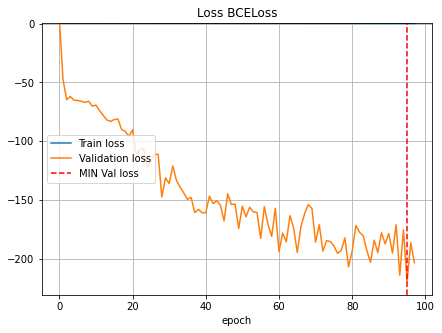

Acc_val (max): 1.02 (1.08) | Loss: 0.1864 | Acc_train: 92.70 |Progress::  32%|###2      | 96/300 [26:09<55:06,…

In [ ]:
model_trainer.fit(data.validation_dataloader,N_EPOCHS, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

In [ ]:
from uncertainty import metrics
RC = metrics.selective_metrics(pre_model,data.test_dataloader)
RC.add_uncs({'Trained Activation':model.Activation_Function})

In [ ]:
RC.d_uncs['Trained Activation'] = -RC.d_uncs['Trained Activation'].view(-1)

In [ ]:
RC.plot_RC()

In [ ]:
model_trainer.hist_val.risk